**Task-1: Inner Workings of ResNet-152**


1. Baseline Setup

In [1]:
from torchvision import models

# Load pre-trained ResNet-152
model = models.resnet152(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:03<00:00, 70.0MB/s]


In [ ]:
import torch.nn as nn

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  # CIFAR-10 has 10 classes

In [ ]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the classification head
for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(224),   # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
val_dataset   = datasets.CIFAR10('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training function
def train_one_epoch(model, loader):
    model.train()
    correct, total, running_loss = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return running_loss / len(loader), 100 * correct / total

# Validation function
def validate(model, loader):
    model.eval()
    correct, total, running_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return running_loss / len(loader), 100 * correct / total

# Train for 5 epochs
epochs = 5
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


Epoch 1/5 | Train Loss: 0.6695, Train Acc: 77.97% | Val Loss: 0.5093, Val Acc: 82.75%
Epoch 2/5 | Train Loss: 0.5155, Train Acc: 82.19% | Val Loss: 0.5283, Val Acc: 81.92%
Epoch 3/5 | Train Loss: 0.4880, Train Acc: 83.20% | Val Loss: 0.4687, Val Acc: 83.98%
Epoch 4/5 | Train Loss: 0.4722, Train Acc: 83.56% | Val Loss: 0.4600, Val Acc: 84.43%
Epoch 5/5 | Train Loss: 0.4606, Train Acc: 84.17% | Val Loss: 0.4698, Val Acc: 84.16%


In [3]:
# TASK-1
import torch
print(torch.cuda.is_available())

True


2. Residual Connections in Practice

a) Disable Skip Connection

In [ ]:
import torch.nn as nn
from torchvision import models

# Load pre-trained ResNet-152
model = models.resnet152(pretrained=True)

# Freeze backbone except classification head
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# Replace final classification layer for CIFAR-10
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

# -------- Disable skip connections in a few blocks --------
# We will modify some Bottleneck blocks to remove the skip connection

# Access the first layer group (layer1)
for i, block in enumerate(model.layer1):
    if i < 2:  # modify first two residual blocks
        # Save original forward
        original_forward = block.forward

        # Redefine forward without skip connection
        def forward_no_skip(x):
            out = block.conv1(x)
            out = block.bn1(out)
            out = block.relu(out)
            out = block.conv2(out)
            out = block.bn2(out)
            out = block.relu(out)
            out = block.conv3(out)
            out = block.bn3(out)
            # Skip connection removed
            return block.relu(out)

        block.forward = forward_no_skip

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:01<00:00, 187MB/s]


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # This ensures all layers are on GPU

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
def train_one_epoch(model, loader):
    model.train()
    correct, total, running_loss = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100 * correct / total

In [ ]:
def validate(model, loader):
    model.eval()
    correct, total, running_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100 * correct / total

In [ ]:
print(train_one_epoch)

<function train_one_epoch at 0x7c76c16131a0>


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

# Re-initialize the model and apply the corrected skip connection logic
# This duplicates code from previous cells (O5EKw--tIbBG and HZkMI8vkK16U) to make this cell runnable independently.

# Load pre-trained ResNet-152
model = models.resnet152(pretrained=True)

# Freeze backbone except classification head
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# Replace final classification layer for CIFAR-10
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# --- CORRECTED Logic for Disabling Skip Connections ---
def create_forward_no_skip(current_block):
    """
    Factory function to create a new forward method for a Bottleneck block
    that disables the skip connection. It correctly captures 'current_block'
    to avoid Python closure issues.
    """
    def forward_no_skip(x):
        out = current_block.conv1(x)
        out = current_block.bn1(out)
        out = current_block.relu(out)
        out = current_block.conv2(out)
        out = current_block.bn2(out)
        out = current_block.relu(out)
        out = current_block.conv3(out)
        out = current_block.bn3(out)
        # Skip connection removed: instead of `identity + out`, just return `out`
        return current_block.relu(out) # Apply final activation
    return forward_no_skip

# Access the first layer group (layer1)
for i, block in enumerate(model.layer1):
    if i < 2:  # modify first two residual blocks
        # Assign the new forward method created by the factory function
        block.forward = create_forward_no_skip(block)

# Re-initialize data loaders, loss function, and optimizer (as originally intended by this cell)
transform = transforms.Compose([
    transforms.Resize(224),   # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
val_dataset   = datasets.CIFAR10('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training and validation functions (train_one_epoch, validate) are assumed to be defined in previous cells

epochs = 5
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 | Train Loss: 1.6185, Train Acc: 43.29% | Val Loss: 1.5363, Val Acc: 45.79%
Epoch 2/5 | Train Loss: 1.4583, Train Acc: 48.54% | Val Loss: 1.4395, Val Acc: 49.88%
Epoch 3/5 | Train Loss: 1.4296, Train Acc: 49.64% | Val Loss: 1.4027, Val Acc: 50.31%
Epoch 4/5 | Train Loss: 1.4100, Train Acc: 50.31% | Val Loss: 1.3985, Val Acc: 50.21%
Epoch 5/5 | Train Loss: 1.3815, Train Acc: 51.37% | Val Loss: 1.4344, Val Acc: 49.14%


In [ ]:
# Train for 5 epochs
epochs = 5
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/5 | Train Loss: 1.3717, Train Acc: 51.93% | Val Loss: 1.4464, Val Acc: 49.82%
Epoch 2/5 | Train Loss: 1.3594, Train Acc: 52.23% | Val Loss: 1.3507, Val Acc: 52.61%
Epoch 3/5 | Train Loss: 1.3362, Train Acc: 53.02% | Val Loss: 1.3127, Val Acc: 53.82%
Epoch 4/5 | Train Loss: 1.3351, Train Acc: 52.95% | Val Loss: 1.3368, Val Acc: 52.88%
Epoch 5/5 | Train Loss: 1.3280, Train Acc: 53.46% | Val Loss: 1.3008, Val Acc: 54.35%


3. Feature Hierarchies and Representations

a) Collect Features  from early, middle, and late layers of the network.

In [5]:
import torch
import numpy as np
from torchvision import models
import torch.nn as nn

# Load trained model (baseline ResNet-152)
model.eval()
model = model.to(device)

# Dictionary to store features
features = {
    "early": [],
    "middle": [],
    "late": []
}

# Hook functions
def hook_early(module, input, output):
    features["early"].append(output.detach().cpu())

def hook_middle(module, input, output):
    features["middle"].append(output.detach().cpu())

def hook_late(module, input, output):
    features["late"].append(output.detach().cpu())

# Register hooks
model.layer1.register_forward_hook(hook_early)
model.layer3.register_forward_hook(hook_middle)
model.layer4.register_forward_hook(hook_late)


In [ ]:
# Collect features from validation set
labels_list = []

# --- Fix: Re-define val_loader if it's not in scope ---
# This part is copied from RNqBnJz5flRu to ensure val_loader exists
# in case the relevant setup cells were not run or the kernel restarted.
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# CIFAR-10 dataset transformation (as defined in previous setup cells)
transform = transforms.Compose([
    transforms.Resize(224),   # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# Load validation dataset and create data loader
val_dataset   = datasets.CIFAR10('./data', train=False, download=True, transform=transform)
val_loader    = DataLoader(val_dataset, batch_size=64, shuffle=False)
# --- End Fix ---

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        model(images)
        labels_list.extend(labels.numpy())

labels_list = np.array(labels_list)


100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


In [1]:
def flatten_features(feat_list):
    feat = torch.cat(feat_list, dim=0)
    feat = torch.mean(feat, dim=[2, 3])  # Global Average Pooling
    return feat.numpy()

early_feat  = flatten_features(features["early"])
middle_feat = flatten_features(features["middle"])
late_feat   = flatten_features(features["late"])


NameError: name 'features' is not defined

In [2]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(features, labels, title):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(6,6))
    scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap="tab10", s=5)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.show()

plot_tsne(early_feat, labels_list, "t-SNE: Early Layer Features")
plot_tsne(middle_feat, labels_list, "t-SNE: Middle Layer Features")
plot_tsne(late_feat, labels_list, "t-SNE: Late Layer Features")


NameError: name 'early_feat' is not defined

Task 2: Understanding Vision Transformers (ViT)

In [1]:
!pip install -q transformers timm pillow


In [2]:
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests


In [3]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [4]:
model_name = "google/vit-base-patch16-224"

processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)

model.eval()


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [5]:
image_urls = [
    "https://img1.hscicdn.com/image/upload//lsci/db/PICTURES/CMS/320400/320448.png",
    "https://www.nation.com.pk/print_images/large/2020-01-01/2019-was-a-great-year-for-me-says-babar-azam-1577821617-3912.jpg"
]

images = [Image.open(requests.get(url, stream=True).raw).convert("RGB") for url in image_urls]


In [6]:
inputs = processor(images=images, return_tensors="pt")


In [7]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predicted_class_ids = logits.argmax(dim=-1)


In [8]:
for i, class_id in enumerate(predicted_class_ids):
    label = model.config.id2label[class_id.item()]
    print(f"Image {i+1} → Top-1 Prediction: {label}")


Image 1 → Top-1 Prediction: jersey, T-shirt, tee shirt
Image 2 → Top-1 Prediction: sweatshirt


2.2 Visualizing Patch Attention:

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests
import cv2


In [10]:
model_name = "google/vit-base-patch16-224"

processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)
model.eval()


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [11]:
url = "https://sportsandgames.co.tt/wp-content/uploads/2022/05/blog_football.jpg.webp"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")


In [12]:
inputs = processor(images=image, return_tensors="pt")


In [17]:
model.set_attn_implementation('eager')
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

attentions = outputs.attentions

In [19]:
print(attentions[0].shape)

torch.Size([1, 12, 197, 197])


In [21]:
# Take last transformer layer
last_layer_attention = attentions[-1]  # shape: (1, heads, seq_len, seq_len)

# Average over heads
avg_attention = last_layer_attention.mean(dim=1)  # (1, seq_len, seq_len)

# CLS token is index 0
cls_attention = avg_attention[0, 0, 1:]  # attention from CLS to patch tokens


In [22]:
num_patches = int(np.sqrt(cls_attention.shape[0]))
attention_map = cls_attention.reshape(num_patches, num_patches).cpu().numpy()


In [23]:
attention_map = attention_map / attention_map.max()  # normalize
attention_map_resized = cv2.resize(attention_map, (224, 224))


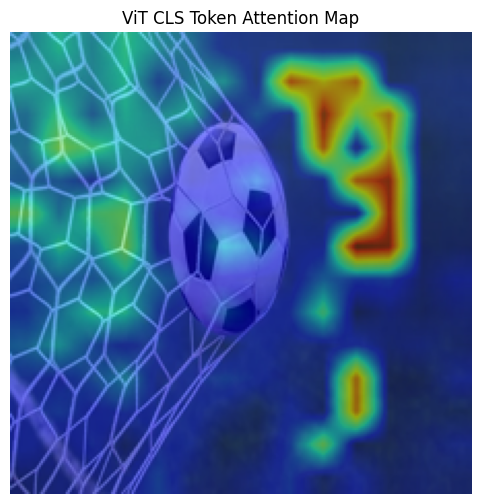

In [24]:
image_np = np.array(image.resize((224, 224)))

plt.figure(figsize=(6,6))
plt.imshow(image_np)
plt.imshow(attention_map_resized, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title("ViT CLS Token Attention Map")
plt.show()


2.3 Analyze the Attention Map:

Task 3: Training Variational Autoencoders

3.1 Train the VAE

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [2]:
# Transform: convert to tensor and normalize to [0,1]
transform = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

val_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


100%|██████████| 26.4M/26.4M [00:01<00:00, 18.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 327kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.17MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.5MB/s]


In [15]:
import torch.nn as nn
import torch

class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.image_size = image_size
        self.z_dim = z_dim

        # Encoder
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2_mu = nn.Linear(h_dim, z_dim)
        self.fc2_logvar = nn.Linear(h_dim, z_dim)

        # Decoder
        self.fc3 = nn.Linear(z_dim, h_dim)
        self.fc4 = nn.Linear(h_dim, image_size)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h))

    def forward(self, x):
        x = x.view(-1, self.image_size) # Flatten the image
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [21]:
import torch.nn.functional as F

def vae_loss(recon_x, x, mu, logvar):
    # Flatten the input x to match recon_x
    x_flattened = x.view(x.size(0), -1)
    # Reconstruction loss
    mse = F.mse_loss(recon_x, x_flattened, reduction='sum')

    # KL divergence
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return mse + kl, mse, kl

In [16]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [22]:
def train_epoch(model, loader):
    model.train()
    total_loss, total_mse, total_kl = 0, 0, 0

    for x, _ in loader:
        x = x.to(device)

        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)

        loss, mse, kl = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_mse += mse.item()
        total_kl += kl.item()

    return total_loss / len(loader.dataset), total_mse / len(loader.dataset), total_kl / len(loader.dataset)


In [23]:
def validate_epoch(model, loader):
    model.eval()
    total_loss, total_mse, total_kl = 0, 0, 0

    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            recon_x, mu, logvar = model(x)

            loss, mse, kl = vae_loss(recon_x, x, mu, logvar)
            total_loss += loss.item()
            total_mse += mse.item()
            total_kl += kl.item()

    return total_loss / len(loader.dataset), total_mse / len(loader.dataset), total_kl / len(loader.dataset)


In [24]:
epochs = 5

train_losses, val_losses = [], []

for epoch in range(epochs):
    train_loss, train_mse, train_kl = train_epoch(model, train_loader)
    val_loss, val_mse, val_kl = validate_epoch(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {train_loss:.4f} (MSE: {train_mse:.4f}, KL: {train_kl:.4f}) | "
        f"Val Loss: {val_loss:.4f} (MSE: {val_mse:.4f}, KL: {val_kl:.4f})"
    )


Epoch 1/5 | Train Loss: 39.4374 (MSE: 32.1306, KL: 7.3067) | Val Loss: 31.4534 (MSE: 23.4946, KL: 7.9588)
Epoch 2/5 | Train Loss: 29.6593 (MSE: 21.6664, KL: 7.9929) | Val Loss: 28.4195 (MSE: 20.8756, KL: 7.5439)
Epoch 3/5 | Train Loss: 27.7481 (MSE: 19.8149, KL: 7.9332) | Val Loss: 27.3588 (MSE: 19.9664, KL: 7.3924)
Epoch 4/5 | Train Loss: 26.8188 (MSE: 18.8354, KL: 7.9834) | Val Loss: 26.5972 (MSE: 18.5766, KL: 8.0206)
Epoch 5/5 | Train Loss: 26.2819 (MSE: 18.2522, KL: 8.0297) | Val Loss: 26.0124 (MSE: 18.1022, KL: 7.9103)


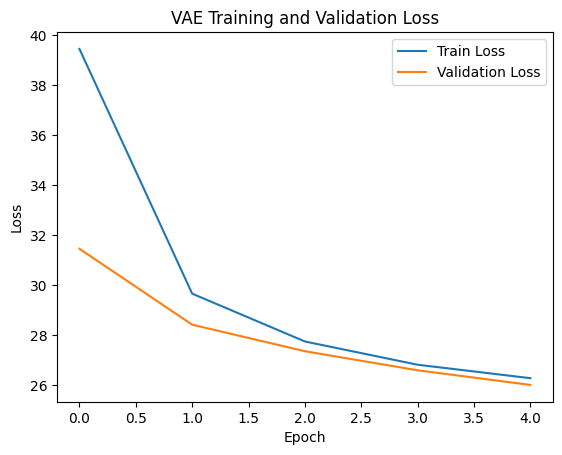

In [25]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Training and Validation Loss")
plt.show()


3.2 Visualize Reconstructions and Generations

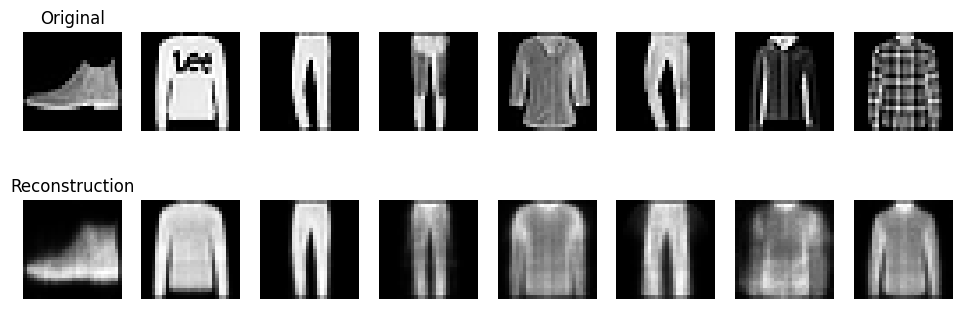

In [27]:
import matplotlib.pyplot as plt

model.eval()

# Get a batch of test images
images, _ = next(iter(val_loader))
images = images.to(device)

with torch.no_grad():
    recon_images, _, _ = model(images)

# Plot originals and reconstructions
n = 8
plt.figure(figsize=(12,4))

for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")
    if i == 0:
        plt.title("Original")

    # Reconstruction
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_images[i].cpu().reshape(28, 28), cmap="gray") # Reshape to 28x28
    plt.axis("off")
    if i == 0:
        plt.title("Reconstruction")

plt.show()

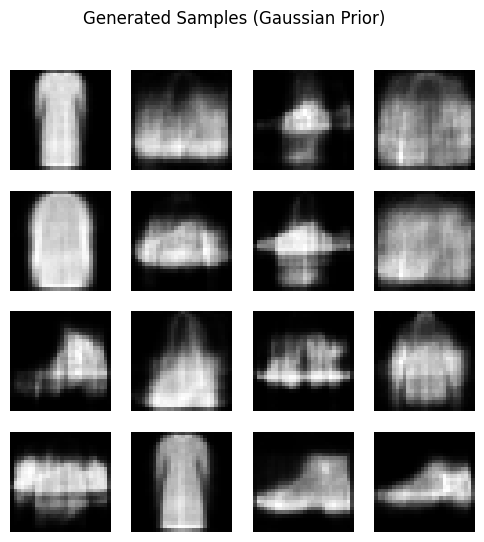

In [30]:
# Number of samples
num_samples = 16

# Get latent dimension from model
latent_dim = model.z_dim  # adjust if named differently

# Sample from standard normal
z = torch.randn(num_samples, latent_dim).to(device)

with torch.no_grad():
    generated = model.decode(z)

# Plot generated images
plt.figure(figsize=(6,6))
for i in range(num_samples):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated[i].cpu().reshape(28, 28), cmap="gray") # Reshape to 28x28
    plt.axis("off")

plt.suptitle("Generated Samples (Gaussian Prior)")
plt.show()

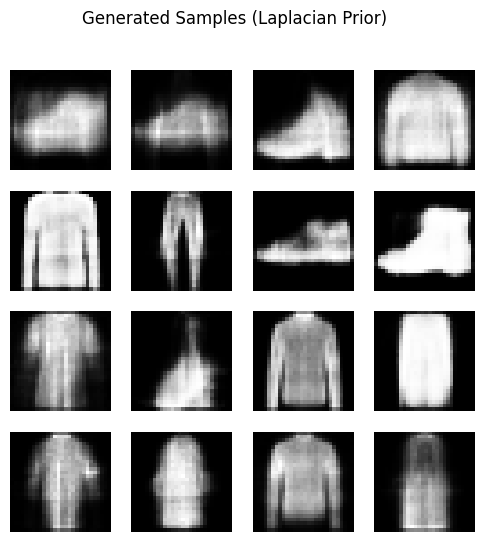

In [32]:
# Sample from Laplace distribution
laplace_dist = torch.distributions.Laplace(
    loc=torch.zeros(latent_dim),
    scale=torch.ones(latent_dim)
)

z_laplace = laplace_dist.sample((num_samples,)).to(device)

with torch.no_grad():
    generated_laplace = model.decode(z_laplace)

# Plot Laplacian samples
plt.figure(figsize=(6,6))
for i in range(num_samples):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_laplace[i].cpu().reshape(28, 28), cmap="gray") # Reshape to 28x28
    plt.axis("off")

plt.suptitle("Generated Samples (Laplacian Prior)")
plt.show()

3.3 Posterior Collapse Investigation


3.4 Mitigating Posterior Collapse


In [36]:
def vae_loss_annealed(recon_x, x, mu, logvar, beta):
    # Flatten the input x to match recon_x
    x_flattened = x.view(x.size(0), -1)
    mse = torch.nn.functional.mse_loss(recon_x, x_flattened, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse + beta * kl, mse, kl

In [34]:
def kl_beta(epoch, max_epoch):
    return min(1.0, epoch / max_epoch)


In [37]:
epochs = 5
train_losses, train_kls = [], []

for epoch in range(epochs):
    model.train()
    beta = kl_beta(epoch, epochs // 2)  # warm-up for half training

    total_loss, total_kl = 0, 0

    for x, _ in train_loader:
        x = x.to(device)

        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)

        loss, mse, kl = vae_loss_annealed(recon_x, x, mu, logvar, beta)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_kl += kl.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_kl = total_kl / len(train_loader.dataset)

    train_losses.append(avg_loss)
    train_kls.append(avg_kl)

    print(f"Epoch {epoch+1}/{epochs} | Beta: {beta:.2f} | Loss: {avg_loss:.4f} | KL: {avg_kl:.4f}")


Epoch 1/5 | Beta: 0.00 | Loss: 12.8236 | KL: 62.7252
Epoch 2/5 | Beta: 0.50 | Loss: 21.3426 | KL: 12.5897
Epoch 3/5 | Beta: 1.00 | Loss: 25.5959 | KL: 8.7034
Epoch 4/5 | Beta: 1.00 | Loss: 25.3173 | KL: 8.4575
Epoch 5/5 | Beta: 1.00 | Loss: 25.0835 | KL: 8.3601


Task 4: Modality Gap in CLIP


4.1 Zero-Shot Classification on STL-10


In [38]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [39]:
# Image preprocessing (CLIP specific)
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.48145466, 0.4578275, 0.40821073),
        std=(0.26862954, 0.26130258, 0.27577711)
    )
])

test_dataset = datasets.STL10(
    root="./data",
    split="test",
    download=True,
    transform=preprocess
)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 2.64G/2.64G [02:25<00:00, 18.2MB/s]


In [40]:
!pip install -q git+https://github.com/openai/CLIP.git


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00


In [41]:
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load("ViT-B/32", device=device)
model.eval()


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 67.9MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [42]:
class_names = [
    "airplane", "bird", "car", "cat", "deer",
    "dog", "horse", "monkey", "ship", "truck"
]


In [43]:
prompts_plain = class_names


In [44]:
prompts_simple = [f"a photo of a {c}" for c in class_names]


In [45]:
prompts_descriptive = [
    f"a high quality photo of a {c}, a type of object" for c in class_names
]


In [46]:
def zeroshot_accuracy(prompts):
    text_tokens = clip.tokenize(prompts).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            logits = image_features @ text_features.T
            preds = logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total


In [48]:
acc_plain = zeroshot_accuracy(prompts_plain)
acc_simple = zeroshot_accuracy(prompts_simple)
acc_desc = zeroshot_accuracy(prompts_descriptive)

print(f"Plain labels accuracy: {acc_plain:.2f}%")
print(f"Simple prompt accuracy: {acc_simple:.2f}%")
print(f"Descriptive prompt accuracy: {acc_desc:.2f}%")


KeyboardInterrupt: 

In [50]:
import matplotlib.pyplot as plt

methods = ["Plain", "Simple Prompt", "Descriptive Prompt"]
accuracies = [acc_plain, acc_simple, acc_desc]

plt.bar(methods, accuracies)
plt.ylabel("Zero-Shot Accuracy (%)")
plt.title("CLIP Zero-Shot Performance on STL-10")
plt.show()


NameError: name 'acc_simple' is not defined

4.2 Exploring the Modality Gap

In [51]:
import torch
import clip
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset


In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load("ViT-B/32", device=device)
model.eval()


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [53]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.48145466, 0.4578275, 0.40821073),
        std=(0.26862954, 0.26130258, 0.27577711)
    )
])

dataset = datasets.STL10(
    root="./data",
    split="test",
    download=True,
    transform=preprocess
)

subset_indices = list(range(100))
subset = Subset(dataset, subset_indices)
loader = DataLoader(subset, batch_size=32, shuffle=False)


In [54]:
class_names = [
    "airplane", "bird", "car", "cat", "deer",
    "dog", "horse", "monkey", "ship", "truck"
]

text_prompts = [f"a photo of a {c}" for c in class_names]


In [55]:
image_embeddings = []
image_labels = []

with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        feats = model.encode_image(images)
        image_embeddings.append(feats.cpu())
        image_labels.extend(labels.numpy())

image_embeddings = torch.cat(image_embeddings, dim=0).numpy()
image_labels = np.array(image_labels)


In [56]:
with torch.no_grad():
    text_tokens = clip.tokenize(text_prompts).to(device)
    text_embeddings = model.encode_text(text_tokens).cpu().numpy()


In [57]:
from sklearn.manifold import TSNE


In [58]:
def l2_normalize(x):
    return x / np.linalg.norm(x, axis=1, keepdims=True)

image_embeddings_norm = l2_normalize(image_embeddings)
text_embeddings_norm = l2_normalize(text_embeddings)


In [59]:
combined = np.vstack([image_embeddings_norm, text_embeddings_norm])

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
proj = tsne.fit_transform(combined)

img_proj = proj[:len(image_embeddings_norm)]
txt_proj = proj[len(image_embeddings_norm):]


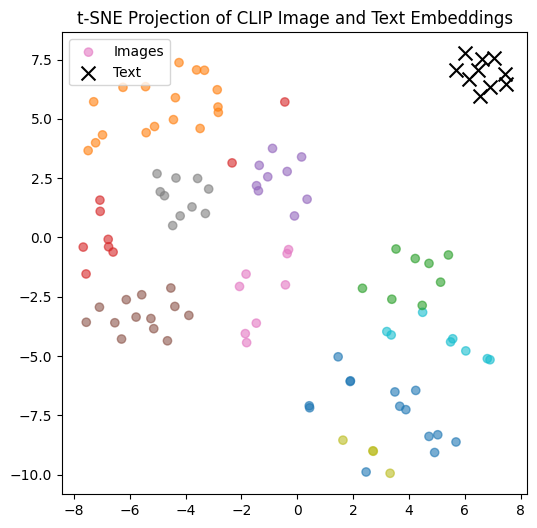

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(img_proj[:,0], img_proj[:,1], c=image_labels, cmap="tab10", alpha=0.6, label="Images")
plt.scatter(txt_proj[:,0], txt_proj[:,1], c="black", marker="x", s=100, label="Text")
plt.legend()
plt.title("t-SNE Projection of CLIP Image and Text Embeddings")
plt.show()


4.3 Bridging the Modality Gap


In [61]:
import numpy as np
import torch
import clip
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from scipy.linalg import orthogonal_procrustes
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load("ViT-B/32", device=device)
model.eval()


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [63]:
# STL-10 classes
class_names = [
    "airplane", "bird", "car", "cat", "deer",
    "dog", "horse", "monkey", "ship", "truck"
]

text_prompts = [f"a photo of a {c}" for c in class_names]

# Text embeddings
with torch.no_grad():
    text_tokens = clip.tokenize(text_prompts).to(device)
    text_features = model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.cpu().numpy()


In [64]:
# Image embeddings (subset of 100)
image_features = []
paired_text_features = []
labels_list = []

with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        feats = model.encode_image(images)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        feats = feats.cpu().numpy()

        image_features.append(feats)
        paired_text_features.append(text_features[labels.numpy()])
        labels_list.extend(labels.numpy())

X = np.vstack(image_features)          # image embeddings
Y = np.vstack(paired_text_features)    # matched text embeddings
labels_list = np.array(labels_list)


In [65]:
R, _ = orthogonal_procrustes(X, Y)


In [66]:
X_aligned = X @ R


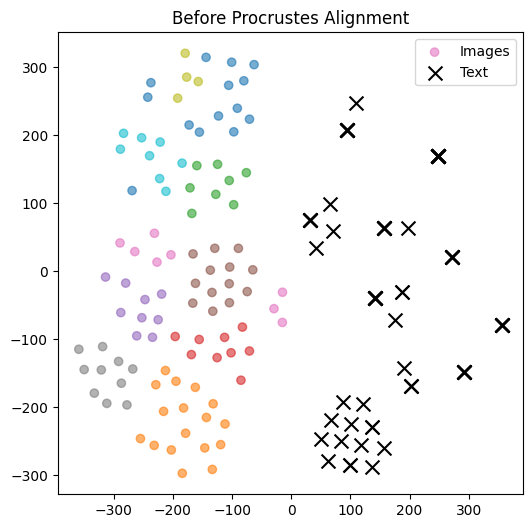

In [67]:
tsne = TSNE(n_components=2, random_state=42)
proj_before = tsne.fit_transform(np.vstack([X, Y]))

img_before = proj_before[:len(X)]
txt_before = proj_before[len(X):]

plt.figure(figsize=(6,6))
plt.scatter(img_before[:,0], img_before[:,1], c=labels_list, cmap="tab10", alpha=0.6, label="Images")
plt.scatter(txt_before[:,0], txt_before[:,1], c="black", marker="x", s=100, label="Text")
plt.title("Before Procrustes Alignment")
plt.legend()
plt.show()


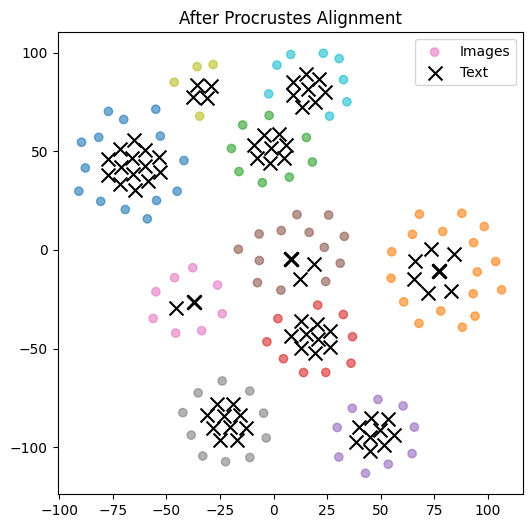

In [68]:
proj_after = tsne.fit_transform(np.vstack([X_aligned, Y]))

img_after = proj_after[:len(X)]
txt_after = proj_after[len(X):]

plt.figure(figsize=(6,6))
plt.scatter(img_after[:,0], img_after[:,1], c=labels_list, cmap="tab10", alpha=0.6, label="Images")
plt.scatter(txt_after[:,0], txt_after[:,1], c="black", marker="x", s=100, label="Text")
plt.title("After Procrustes Alignment")
plt.legend()
plt.show()


In [69]:
def zeroshot_accuracy_from_embeddings(image_feats, text_feats, labels):
    logits = image_feats @ text_feats.T
    preds = logits.argmax(axis=1)
    return 100 * np.mean(preds == labels)

acc_before = zeroshot_accuracy_from_embeddings(X, text_features, labels_list)
acc_after  = zeroshot_accuracy_from_embeddings(X_aligned, text_features, labels_list)

print(f"Accuracy before alignment: {acc_before:.2f}%")
print(f"Accuracy after alignment: {acc_after:.2f}%")


Accuracy before alignment: 97.00%
Accuracy after alignment: 99.00%
